Models were automatically reconstructed from NCBI RefSeq accession codes with carveme.

For M5:

```
carve --refseq GCF_002238085.1 --gapfill m5_med -i m5_med --mediadb medium.tsv -o GEMs/M5.xml 
```

In [23]:
from cobra.io import read_sbml_model
from utils import model_validation as mv

m5 = read_sbml_model('GEMs/M5.xml')

# Gapfilling

The model was gapfilled to grow on the specified medium. This was done during the construction process so that genomic evidence could be taken into account during the process.
Comparison of the non-gapfilled and the gapfilled models will follow.

In [27]:
m5_original = read_sbml_model("GEMs/M5_nogapfill.xml")

print('before gapfilling there were', len(m5_original.reactions), 'reactions')
print('after before gapfilling there were', len(m5.reactions), 'reactions')
# get all reactions that are present in the gapfilled but not the original model
print('the added reactions are:')
print([r.id for r in m5.reactions if r not in m5_original.reactions])

before gapfilling there were 1812 reactions
after before gapfilling there were 1815 reactions
the added reactions are:
['2S6HCCi', 'SUCBZL_1', 'SUCBZS']


# Testing the model:

A sanity-check on the model and its capabilities should include:

1. check whether growth is possible on the medium,  
use ```growth_possible```.

1. check for energy-gerating cycles,  
use ```energy_generation_cycle```

1. check whether the exhange reactions exist in the model,  
use ```reactions_exist```.

2. check whether the exhange reactions are blocked,  
use ```check_blocked_reactions```.

2. check whether the exhange reactions can carry flux at optimal solution (FVA),  
use ```check_production```.

In [2]:
mv.growth_possible(m5)

True

In [3]:
mv.energy_generation_cycle(m5)

False

In [6]:
uptake_reactions = [
    'EX_xyl__D_e', # xylose exchange
]

production_reactions = [
    'EX_btoh_e', # butanol exhange
    'EX_etoh_e', # ethanol exchange
    'EX_ac_e', # acetate exchange
    'EX_but_e', # butyrate exchange
    #'EX_acetone_e', # acetone exchange
]

In [8]:
print(mv.reactions_exist(m5, uptake_reactions))
print(mv.reactions_exist(m5, production_reactions))

True
The following reactions are missing: ['EX_btoh_e', 'EX_acetone_e']
False


In [10]:
existing_production_reactions = [
    'EX_etoh_e', # ethanol exchange
    'EX_ac_e', # acetate exchange
    'EX_but_e', # butyrate exchange
]

mv.check_blocked_reactions(m5, existing_production_reactions)

['EX_etoh_e', 'EX_ac_e', 'EX_but_e']

In [14]:
m5.metabolites.xylan8_e.summary()

Percent,Flux,Reaction,Definition
100.00%,9.128,EX_xylan8_e,xylan8_e <=>
Percent,Flux,Reaction,Definition
100.00%,-9.128,XYLe,h2o_e + xylan8_e --> 2.0 xylan4_e


The out-of-the-box carveme model:
1. can grow on the medium
1. does use xylan as carbon-source (however it seems like xylan8 -> xylan4 is happening extracellularly, and xylan4 -> xylose conversion is happening intracellularly)
1. does not contain the exhange reactions for butanol or acetone
1. does not contain acetone, butyrate, or ethanol production in its solution space

# Troubleshooting

In [3]:
from config import ROOT_DIR

universal_model = read_sbml_model(str(ROOT_DIR / "community_modelling" / "GEMs" / "bigg_universe.xml"))

No objective coefficients in model. Unclear what should be optimized


xylan degredation

In [19]:
def find_rx_from_genes(model, genes):

    for gene, protein in genes.items():
        try:
            gpr = model.genes.get_by_id(protein)
            print(gene, ":", [r.id for r in gpr.reactions])
        except KeyError:
            print(gene, ": not in model")

In [22]:
genes = {'xylanase 1':'WP_237268773_1', 
         'xylanase 2':'WP_094043097_1', 
         'xylosidase': 'WP_094043089_1'}

find_rx_from_genes(m5, genes)

xylanase 1 : ['XYLe']
xylanase 2 : ['XYLe']
xylosidase : not in model


In [70]:
import cobra

# xyl4_e metabolite
xyl4_e = cobra.Metabolite(
    'xyl4_e',
    formula='C20H34O17',
    name='Xylotetraose',
    compartment='C_e')

# xyl_e <-> xyl_c transport rx
xyl4_transport = cobra.Reaction('xyl4_transport')
xyl4_transport.add_metabolites({
    m5.metabolites.get_by_id("xyl4_c"): -1.0,
    xyl4_e: 1.0
})

# glcur_e <-> glcur_c transport rx
glcur_transport = cobra.Reaction('glcur_transport')
glcur_transport.add_metabolites({
    m5.metabolites.get_by_id("glcur_c"): -1.0,
    m5.metabolites.get_by_id("glcur_e"): -1.0,
})

# GLCURS1 rx, extracellular edition
GLCURS1_e = cobra.Reaction('GLCURS1_e')
GLCURS1_e.add_metabolites({
    m5.metabolites.get_by_id("h2o_e"): -1.0,
    m5.metabolites.get_by_id("xylan4_e"): -1.0,
    m5.metabolites.get_by_id("glcur_e"): 1.0,
    xyl4_e: 1.0,
})

# XYLOS1 rx, extracellular edition
XYLOS1_e = cobra.Reaction('XYLOS1_e')
XYLOS1_e.add_metabolites({
    m5.metabolites.get_by_id("h2o_e"): -3.0,
    xyl4_e: -1.0,
    m5.metabolites.get_by_id("xyl__D_e"): 4.0,
})

m5.add_reactions([xyl4_transport, glcur_transport, GLCURS1_e, XYLOS1_e])

- now the model should be capable of producing extracellular xylose (veryfied by setting xylose as objective and solving an FBA problem)

ABE pathway:

In [34]:
metabolites = ['btoh', '1btol', 'btal', 'btcoa', 'butpi', 'but', 'acetone', 'acac', 'aacoa', 'b2coa', '3hbcoa', 'accoa', 'pyr']

for metabolite in metabolites:
    try:
        m5.metabolites.get_by_id(str(metabolite+"_c"))
    except KeyError:
        print(metabolite, "not in model")

butpi not in model
acetone not in model


In [36]:
reactions = ['HBCO_nadp','ACOAD1f', 'BTCOARx', 'ALCD4', 'BTS', 'PBUTT', 'BUTKr', 'BUTCT', 'BUTCT','EX_acetone_e', 'EX_but_e', 'EX_btoh_e']

for reaction in reactions:
    try:
        m5.reactions.get_by_id(reaction)
    except KeyError:
        print(reaction, "not in model")

PBUTT not in model
BUTKr not in model
EX_acetone_e not in model
EX_btoh_e not in model


- modifications are in a sepparate python script in utils/m5_modifications.py

In [26]:
from cobra.io import read_sbml_model
from utils import model_validation as mv

m5 = read_sbml_model('GEMs/M5_curated.xml')

In [8]:
assert mv.growth_possible(m5)
assert not mv.energy_generation_cycle(m5)
assert not mv.check_blocked_reactions(m5, production_reactions)

# Growth coupling of known products

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


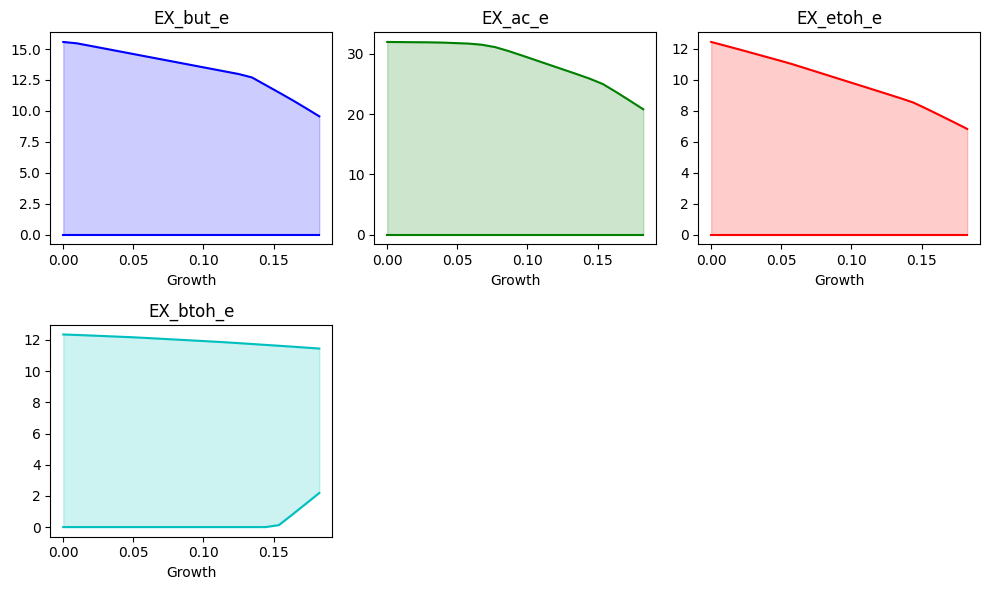

In [27]:
from utils import static_sim

medium = static_sim.get_specific_medium(m5, {"EX_xylan4_e": 1, "EX_xylan8_e": 1})

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"]

static_sim.plot_flux_envelopes(m5, medium=medium, reactions=prod_reactions)

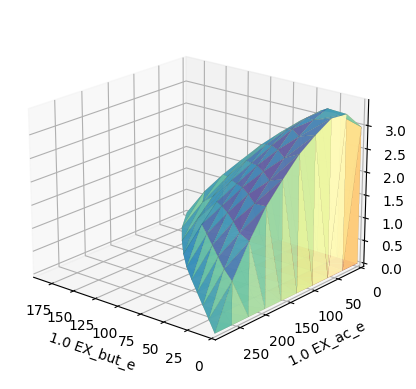

In [34]:
import straindesign as sd
import matplotlib.pyplot as plt

_,_,plot = sd.plot_flux_space(m5,('EX_but_e','EX_ac_e', 'Growth'),points=10, show=False);
plot._axes.view_init(elev=20, azim=130)
plt.show()

seemingly some "mutual" growth coupling (is that a thing?) with the acid products even though no individual reaction is growth-coupled

In [40]:
from utils import static_sim

medium = static_sim.get_specific_medium(m5, {"EX_xyl__D_e": 10})

with m5:
    #m5.medium = medium
    summary = m5.summary()
    sol = m5.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [37]:
summary

Metabolite,Reaction,Flux,C-Number,C-Flux
ala__L_e,EX_ala__L_e,0.1,3,0.59%
arg__L_e,EX_arg__L_e,0.1,6,1.17%
asp__L_e,EX_asp__L_e,0.1,4,0.78%
ca2_e,EX_ca2_e,0.0009503,0,0.00%
cl_e,EX_cl_e,0.0009503,0,0.00%
cobalt2_e,EX_cobalt2_e,1.826E-05,0,0.00%
cu2_e,EX_cu2_e,0.0001295,0,0.00%
cys__L_e,EX_cys__L_e,0.01683,3,0.10%
dcyt_e,EX_dcyt_e,0.1,9,1.76%
fe2_e,EX_fe2_e,0.001226,0,0.00%


In [41]:
import escher
from escher import Builder

builder = Builder(map_json='ABE_pretty.json', model=m5, height=600)
builder.reaction_data = sol.fluxes

In [42]:
builder

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR141tipp': 0.0, '12DGR160tip…

In [22]:
m5.reactions.ECOAH1

Reaction identifier,ECOAH1
Name,3-hydroxyacyl-CoA dehydratase (3-hydroxybutanoyl-CoA)
Memory address,0x123c92f20
Stoichiometry,3hbcoa_c <=> b2coa_c + h2o_c (S)-3-Hydroxybutanoyl-CoA <=> Crotonoyl-CoA + H2O H2O
GPR,WP_015311840_1
Lower bound,-1000.0
Upper bound,1000.0
